# UNet model

Running the UNet from here 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
# import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm
from eval_segm import *

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff

from skimage.filters import threshold_otsu, rank

import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

/home/magdy/cs231n_bmi260_project/Pytorch-UNet/utils/data_vis.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.

In [2]:
NUM_TOTAL = 830
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../../Cystic_masks_new/Train',
                          root_dir='../../Cystic Dataset/Train',
                          mask=True, HU=True, resize=512)

lung_dataset_test = ILDDataset(cystic_path='../../Cystic_masks_new/Test',
                          root_dir='../../Cystic Dataset/Test',
                          mask=True, HU=True, resize=512)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=4)

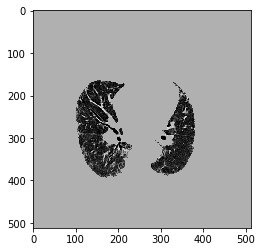

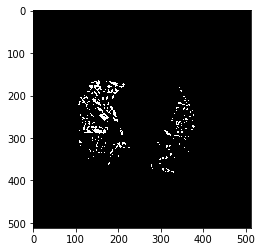

In [3]:
#data sample
sample = lung_dataset_train[23]
plt.imshow(sample[0], cmap="gray")
plt.show()
plt.imshow(sample[1], cmap="gray")
plt.show()

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Check Accuracy

In [5]:
def dice_loss(pred, target):
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return ((2. * intersection) / (A_sum + B_sum) )

In [27]:
def eval_net(net, loader, device, gpu=True):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on val/test set')   

    tot = 0
    tot_pixel_acc = 0
    ADCS_Avg = 0
    cntr = 0
    net.eval()
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                net.cuda()
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)

#             y_pred = (F.sigmoid(y_pred) > 0.5).float()
#             dice = dice_coeff(y_pred, y.float()).data[0]
            probs = F.sigmoid(y_pred)
            y_pred_print = (probs > 0.5)
            pred_cyst_score = np.sum(y_pred_print.cpu().numpy())/np.sum((X.cpu().numpy()>0))
            act_cyst_score = np.sum(y.cpu().numpy())/np.sum((X.cpu().numpy()>0))
            ADCS = np.absolute((pred_cyst_score-act_cyst_score)/act_cyst_score)
            dice = dice_loss(y_pred_print.float(), y)
            
            pixel_acc = pixel_accuracy(y[0,:], y_pred[0,:])
            tot_pixel_acc += pixel_acc
            tot += dice
            ADCS_Avg += ADCS
            cntr += 1
            
            
            
            if 1:
                X = X.data.squeeze(1).cpu().numpy()
                X = np.transpose(X, axes=[1, 2, 0])
                y = y.data.squeeze(1).cpu().numpy()
                y = np.transpose(y, axes=[1, 2, 0])
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])

                print("X")
                plt.imshow(X[:,:,0], cmap='gray')
                plt.show()
                
                print("Predicted Y")
                plt.imshow(y_pred[:,:,0], cmap='gray')
                plt.show()
                
                print("Probs Y")
                plt.imshow(probs[0,0,:,:], cmap='gray')
                plt.show()
                
                print("Print Y")
                plt.imshow(y_pred_print[0,0,:,:], cmap='gray')
                plt.show()
                                
                print("Actual Y")
                plt.imshow(y[:,:,0], cmap='gray')        
                plt.show()
                
                print("dice score: ", dice)
                
    return tot / cntr, tot_pixel_acc / cntr, ADCS_Avg / cntr

# Train

In [11]:
#Train function

def train_net(net, epochs=50, batch_size=4, lr=1e-3, save=True, gpu=True):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    weights = torch.tensor([30, 1], device= device, dtype=dtype)
#     criterion = weighted_binary_cross_entropy(weight=weights)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    all_losses = []
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                net.cuda()
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
#             print(y_pred.shape)
            
            probs = F.sigmoid(y_pred)
            thresh = threshold_otsu(probs.data.cpu().numpy())
            probs_flat = probs.view(-1)
            y_pred_print = (probs > thresh)
            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            all_losses.append(loss)
            epoch_loss += loss.data[0]

            if(t%100 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
        if 0:
            print("X")
            plt.imshow(X.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Predicted Y")
            plt.imshow(y_pred.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Probs Y")
            plt.imshow(probs.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Print Y")
            plt.imshow(y_pred_print.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Actual Y")
            plt.imshow(y.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
#             _ = plt.hist(probs.data.cpu().numpy().reshape([-1]), 1000)
#             plt.ylim([0, 500])
#             plt.plot([thresh, thresh], [0, 500], 'r')
#             plt.show()

        if save:
            torch.save(net.state_dict(),
                       dir_checkpoint + '/batch_sgd/CP{}.pth'.format(epoch+49))

            print('Checkpoint {} saved !'.format(epoch))
            
    return all_losses


In [12]:
net = UNet(1, 1)
# net.load_state_dict(torch.load('checkpoints/batch_04/CP49.pth'))
try:
    all_losses = train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
    np.save('all_losses.pkl', all_losses)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')

Starting epoch 1/50.
0.0000 --- loss: 0.651574
Saved interrupt


In [28]:
net = UNet(1, 1)
net.load_state_dict(torch.load('checkpoints/batch_sgd/CP95.pth'))

Checking accuracy on val/test set
X


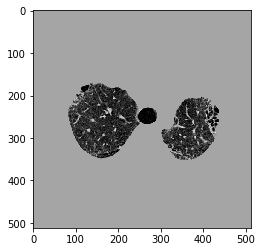

Predicted Y


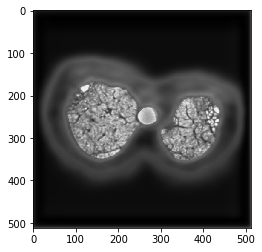

Probs Y


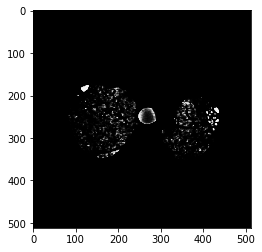

Print Y


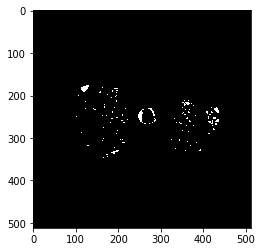

Actual Y


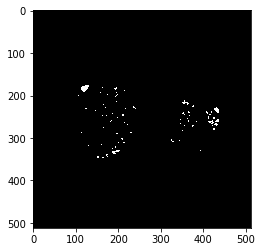

dice score:  tensor(0.9524, device='cuda:0')
X


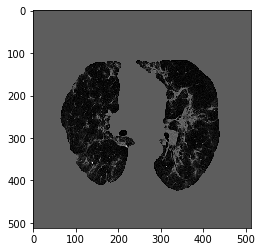

Predicted Y


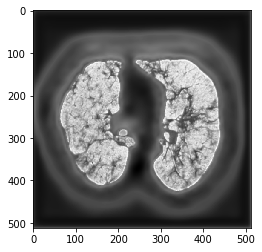

Probs Y


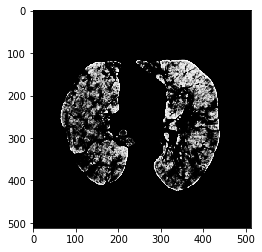

Print Y


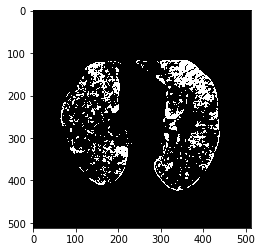

Actual Y


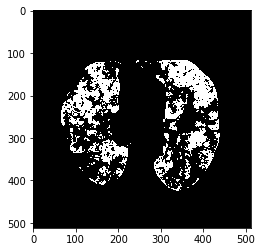

dice score:  tensor(0.7880, device='cuda:0')
X


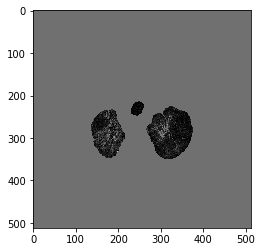

Predicted Y


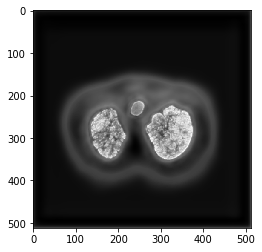

Probs Y


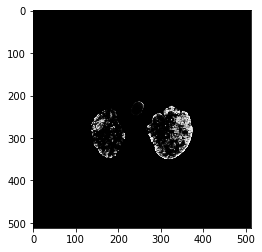

Print Y


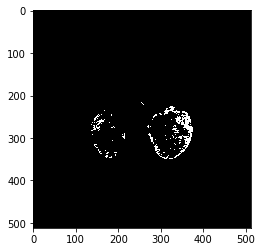

Actual Y


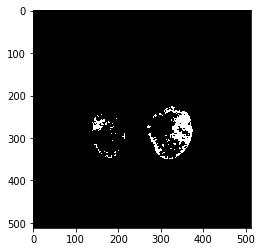

dice score:  tensor(0.8925, device='cuda:0')
X


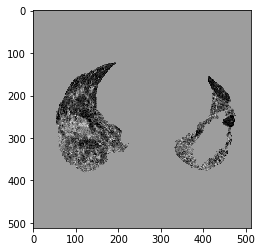

Predicted Y


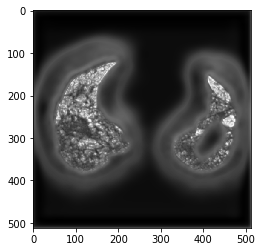

Probs Y


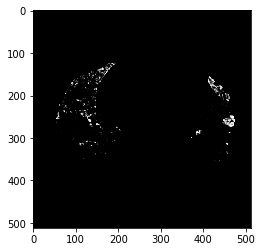

Print Y


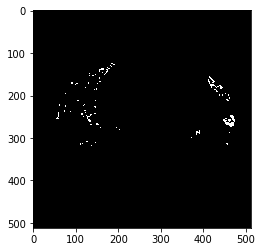

Actual Y


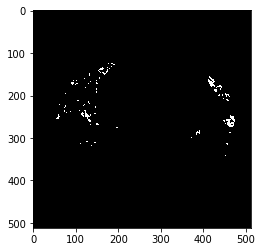

dice score:  tensor(0.8961, device='cuda:0')
X


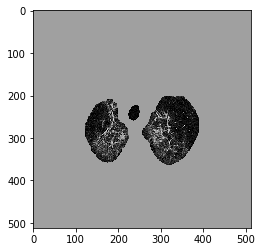

Predicted Y


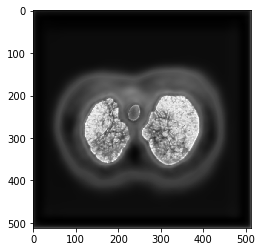

Probs Y


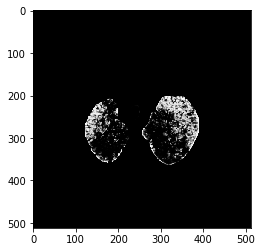

Print Y


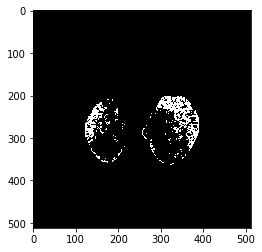

Actual Y


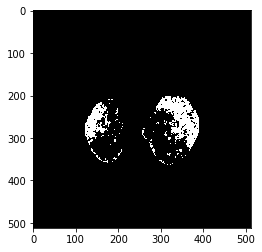

dice score:  tensor(0.9042, device='cuda:0')
X


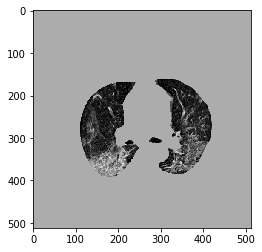

Predicted Y


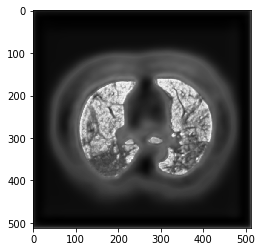

Probs Y


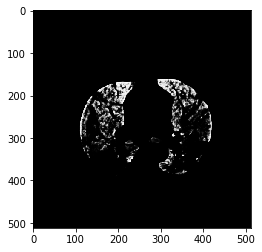

Print Y


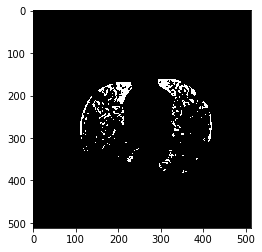

Actual Y


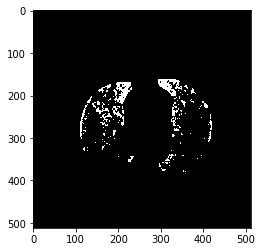

dice score:  tensor(0.9022, device='cuda:0')
X


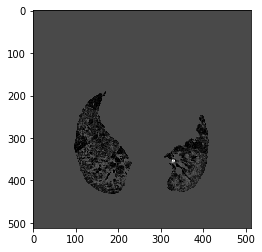

Predicted Y


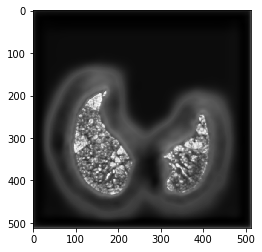

Probs Y


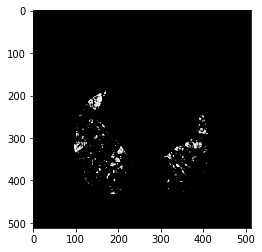

Print Y


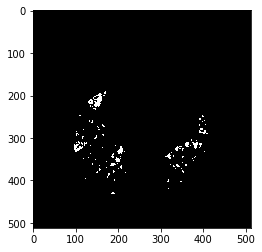

Actual Y


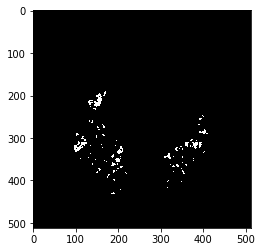

dice score:  tensor(0.9212, device='cuda:0')
X


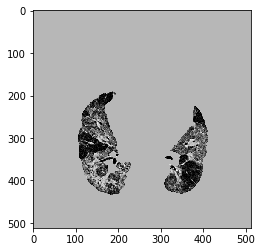

Predicted Y


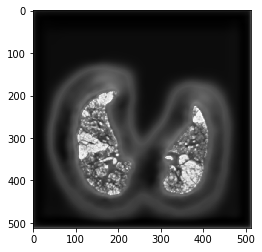

Probs Y


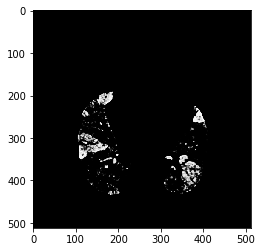

Print Y


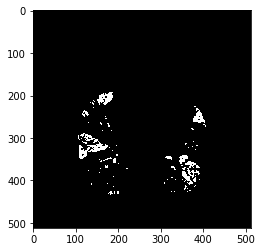

Actual Y


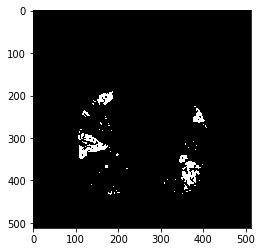

dice score:  tensor(0.8890, device='cuda:0')
X


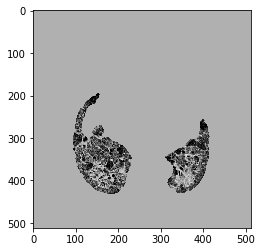

Predicted Y


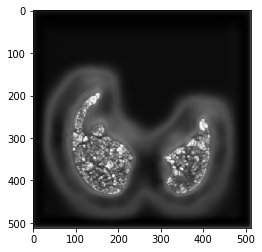

Probs Y


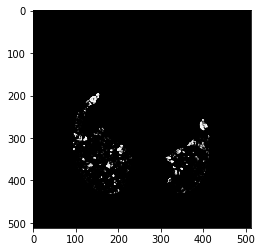

Print Y


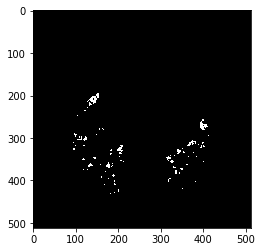

Actual Y


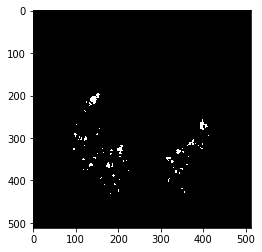

dice score:  tensor(0.8435, device='cuda:0')
X


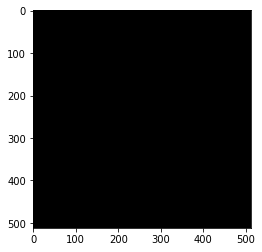

Predicted Y


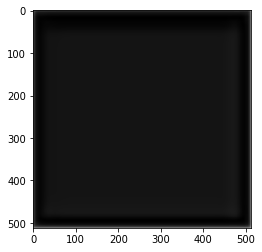

Probs Y


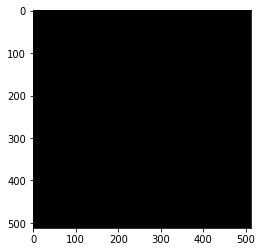

Print Y


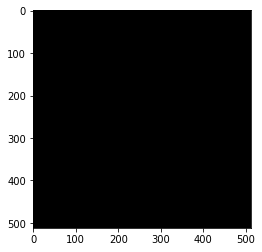

Actual Y


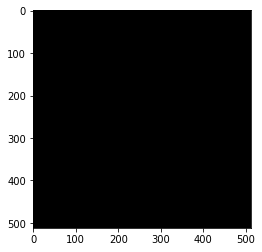

dice score:  tensor(0.9314, device='cuda:0')
X


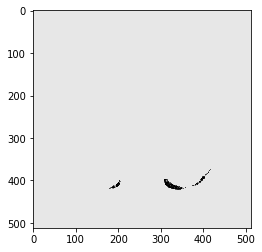

Predicted Y


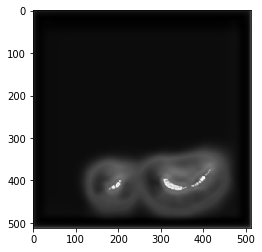

Probs Y


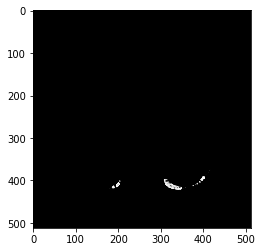

Print Y


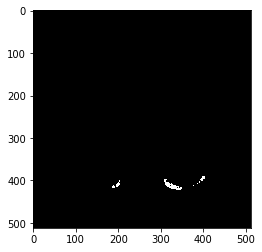

Actual Y


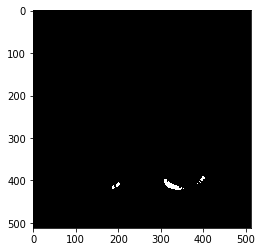

dice score:  tensor(0.7407, device='cuda:0')
X


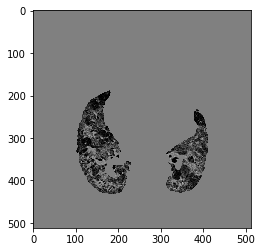

Predicted Y


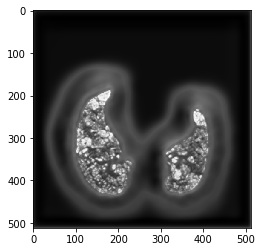

Probs Y


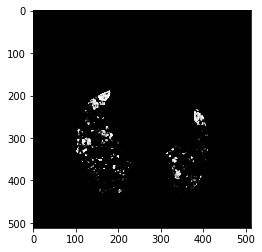

Print Y


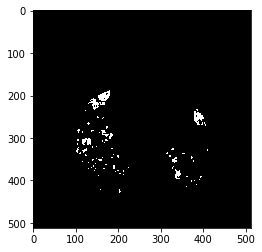

Actual Y


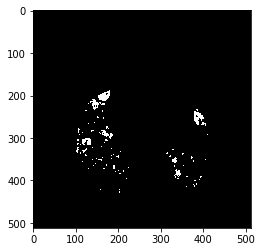

dice score:  tensor(0.7925, device='cuda:0')
X


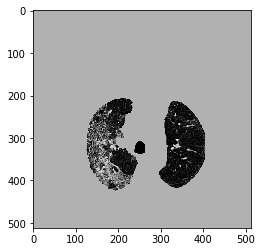

Predicted Y


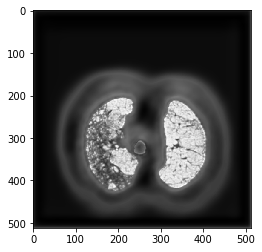

Probs Y


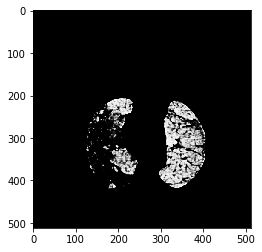

Print Y


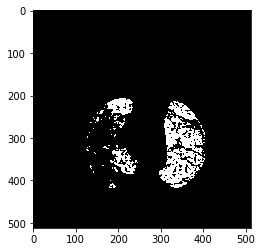

Actual Y


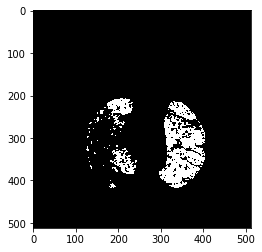

dice score:  tensor(0.9461, device='cuda:0')
X


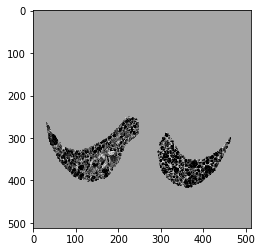

Predicted Y


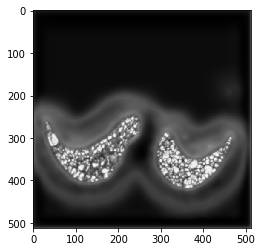

Probs Y


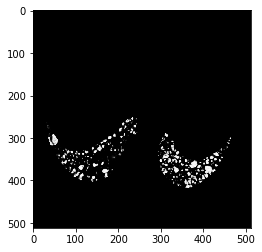

Print Y


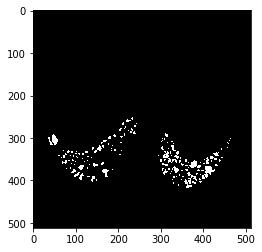

Actual Y


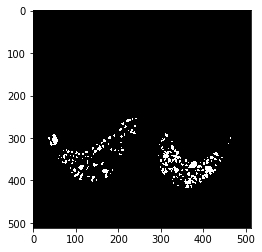

dice score:  tensor(0.9369, device='cuda:0')
X


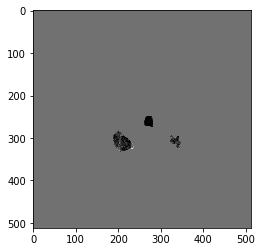

Predicted Y


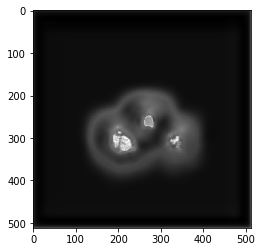

Probs Y


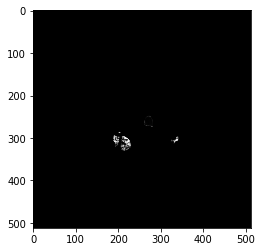

Print Y


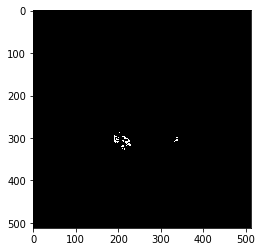

Actual Y


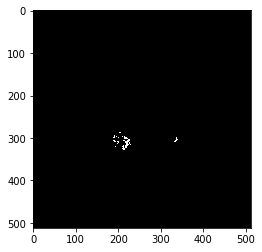

dice score:  tensor(0.9525, device='cuda:0')
X


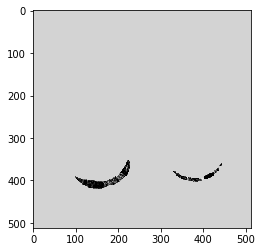

Predicted Y


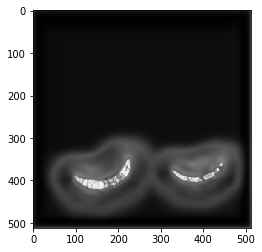

Probs Y


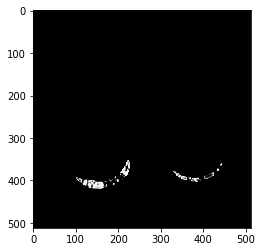

Print Y


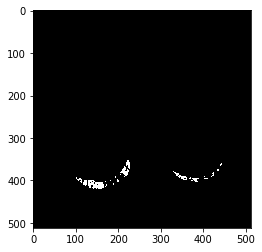

Actual Y


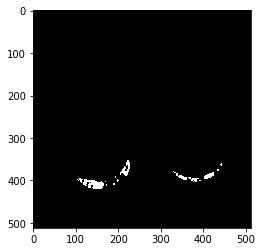

dice score:  tensor(0.9547, device='cuda:0')
X


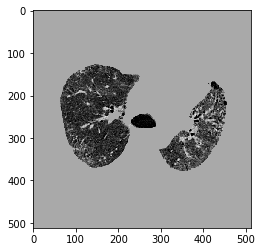

Predicted Y


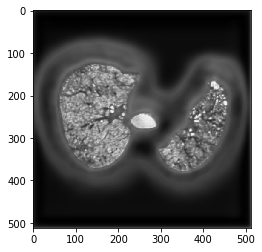

Probs Y


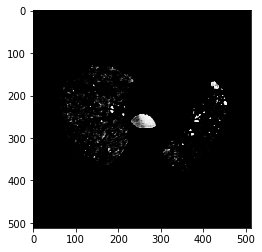

Print Y


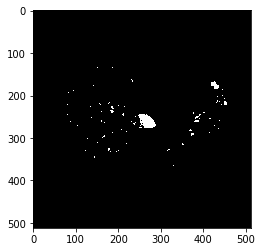

Actual Y


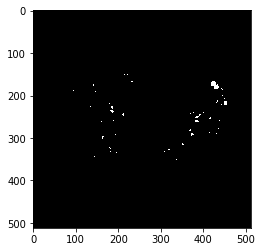

dice score:  tensor(0.9393, device='cuda:0')
X


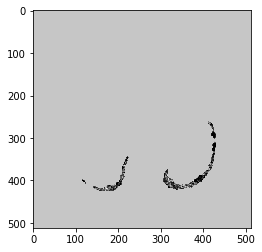

Predicted Y


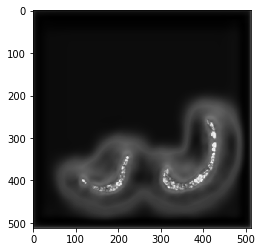

Probs Y


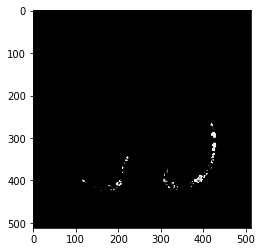

Print Y


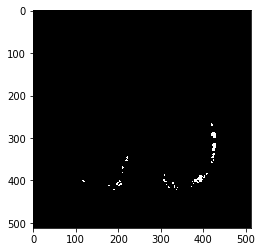

Actual Y


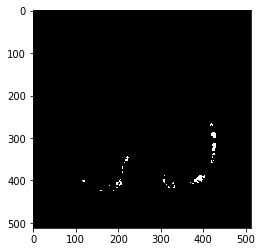

dice score:  tensor(0.7381, device='cuda:0')
X


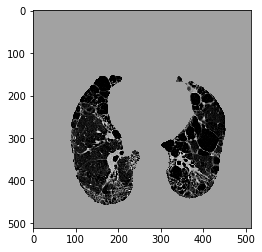

Predicted Y


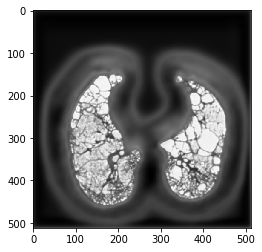

Probs Y


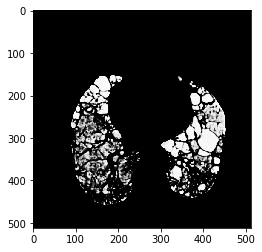

Print Y


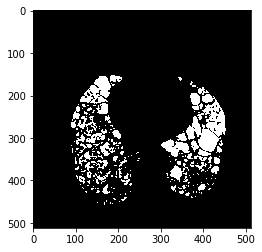

Actual Y


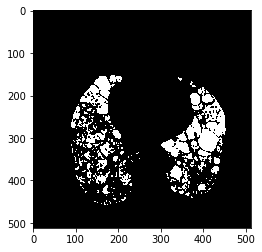

dice score:  tensor(0.9493, device='cuda:0')
X


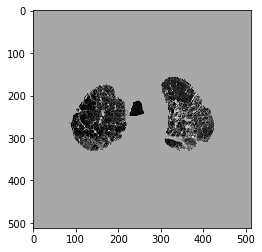

Predicted Y


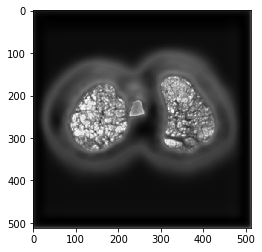

Probs Y


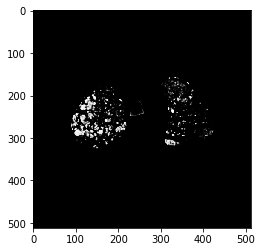

Print Y


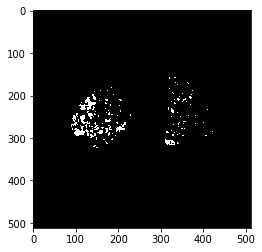

Actual Y


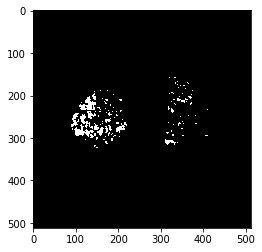

dice score:  tensor(0.8987, device='cuda:0')
X


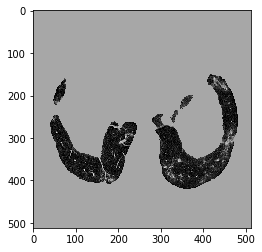

Predicted Y


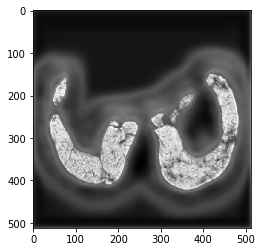

Probs Y


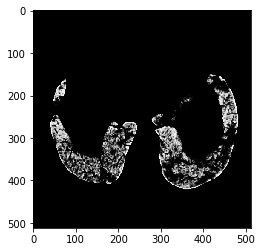

Print Y


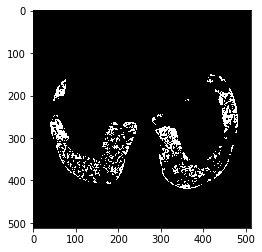

Actual Y


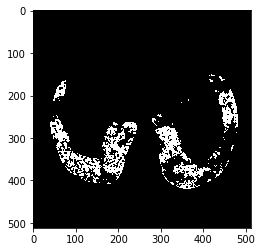

dice score:  tensor(0.7757, device='cuda:0')
X


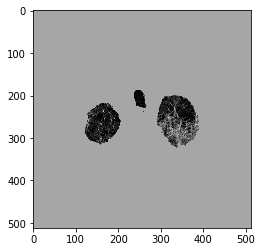

Predicted Y


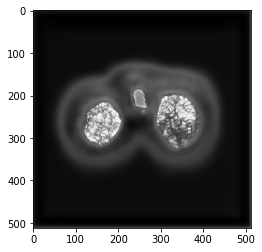

Probs Y


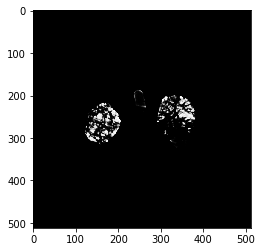

Print Y


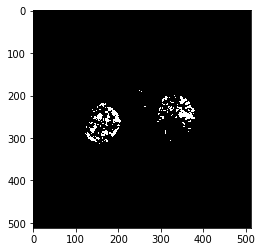

Actual Y


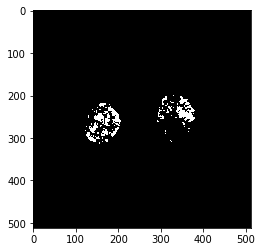

dice score:  tensor(0.8552, device='cuda:0')
X


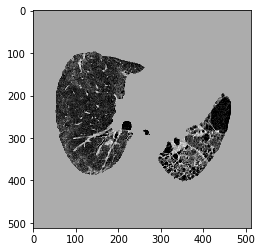

Predicted Y


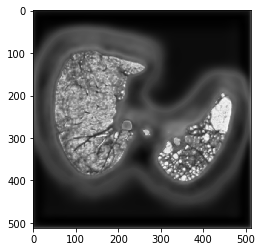

Probs Y


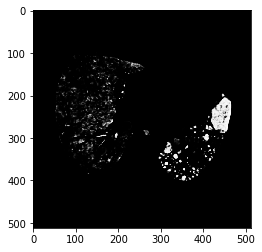

Print Y


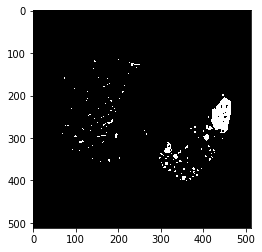

Actual Y


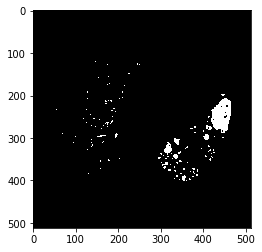

dice score:  tensor(0.9152, device='cuda:0')
X


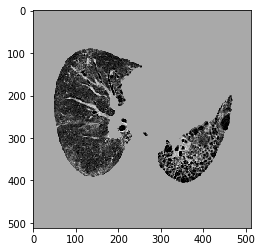

Predicted Y


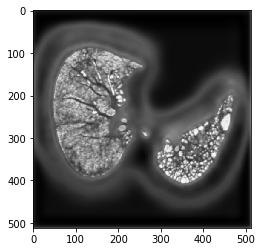

Probs Y


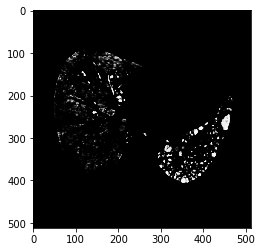

Print Y


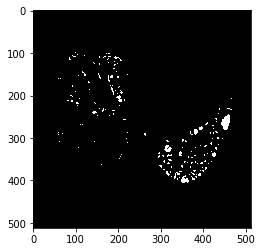

Actual Y


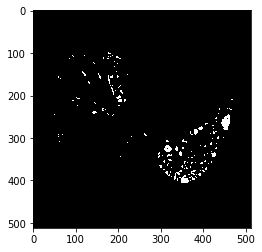

dice score:  tensor(0.7401, device='cuda:0')
X


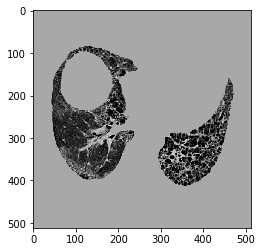

Predicted Y


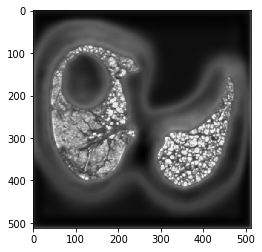

Probs Y


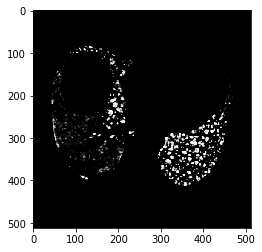

Print Y


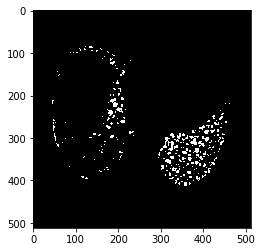

Actual Y


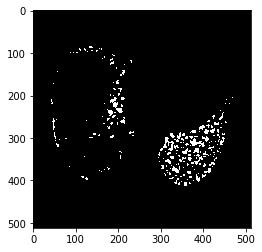

dice score:  tensor(0.9300, device='cuda:0')
X


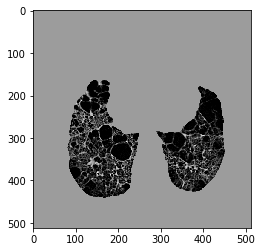

Predicted Y


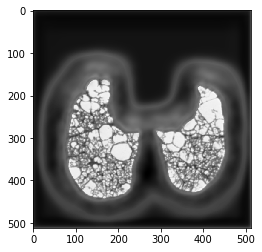

Probs Y


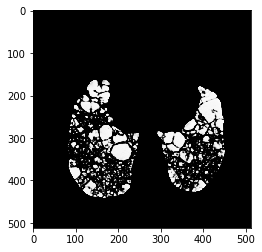

Print Y


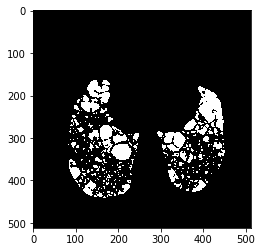

Actual Y


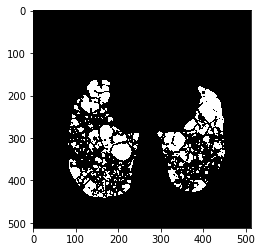

dice score:  tensor(0.9436, device='cuda:0')
X


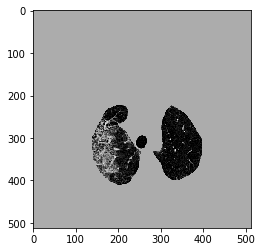

Predicted Y


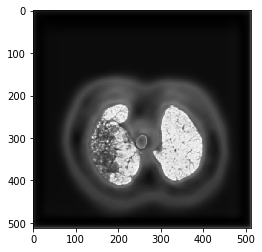

Probs Y


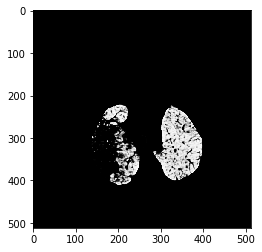

Print Y


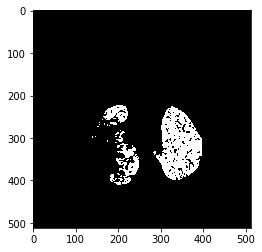

Actual Y


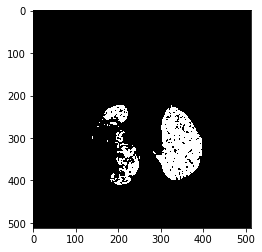

dice score:  tensor(0.9514, device='cuda:0')
X


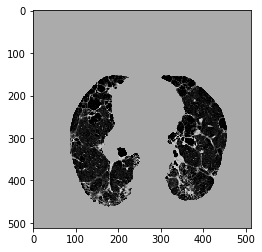

Predicted Y


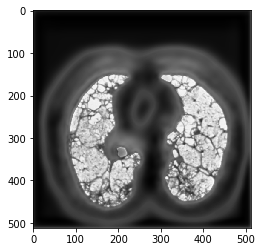

Probs Y


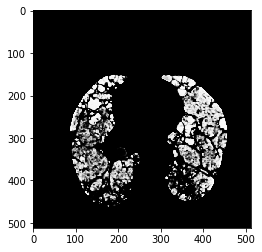

Print Y


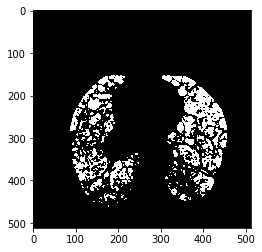

Actual Y


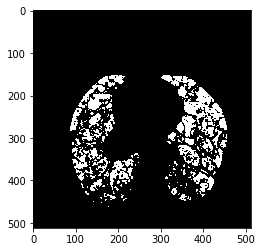

dice score:  tensor(0.8059, device='cuda:0')
X


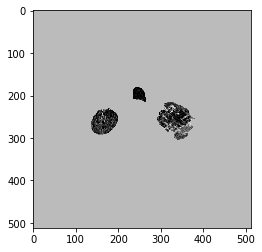

Predicted Y


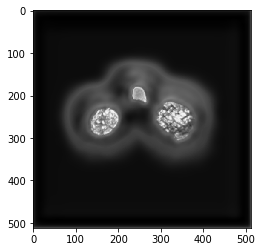

Probs Y


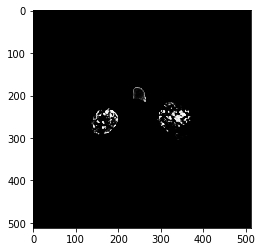

Print Y


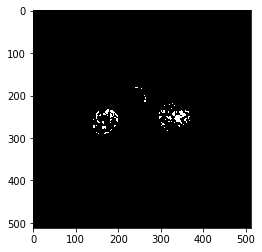

Actual Y


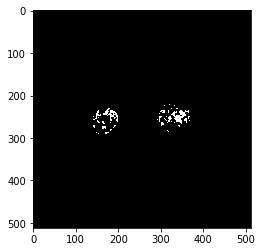

dice score:  tensor(0.9426, device='cuda:0')
X


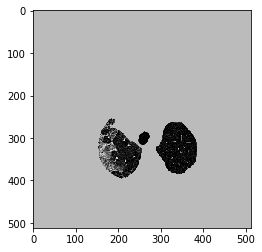

Predicted Y


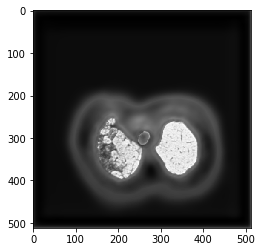

Probs Y


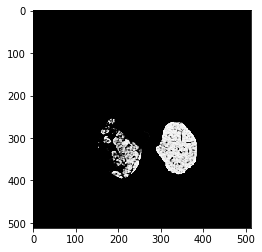

Print Y


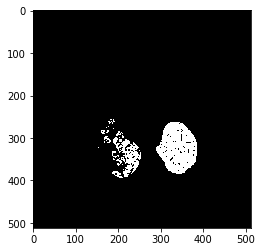

Actual Y


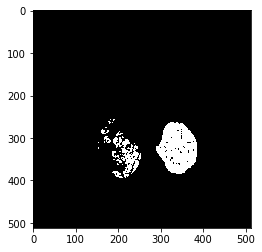

dice score:  tensor(0.9634, device='cuda:0')
X


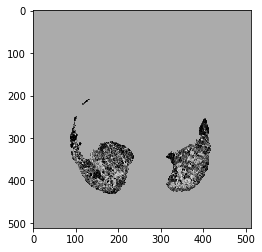

Predicted Y


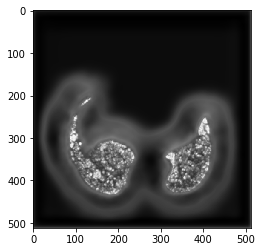

Probs Y


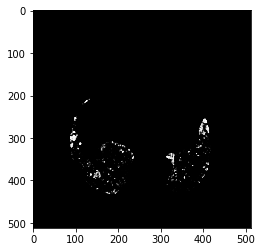

Print Y


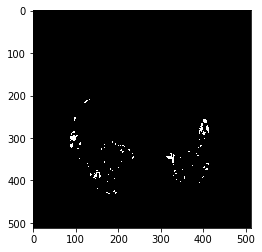

Actual Y


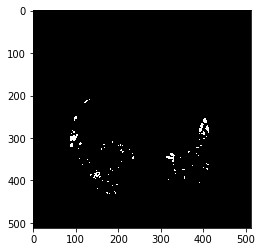

dice score:  tensor(0.8838, device='cuda:0')
X


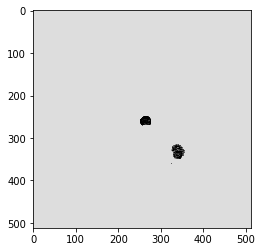

Predicted Y


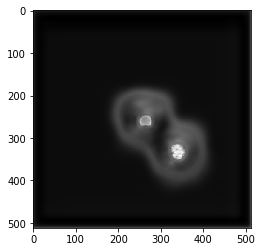

Probs Y


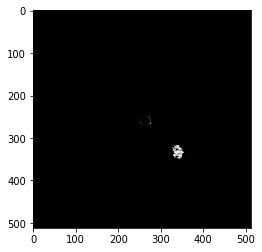

Print Y


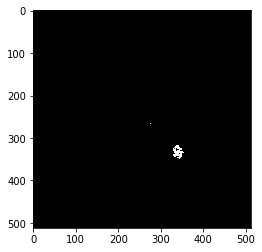

Actual Y


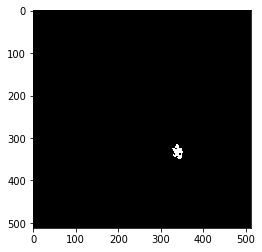

dice score:  tensor(0.8805, device='cuda:0')
X


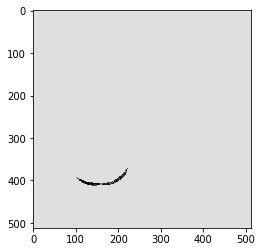

Predicted Y


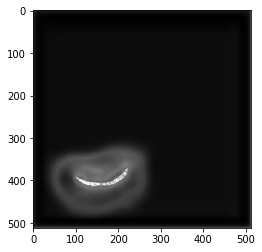

Probs Y


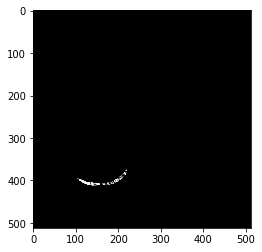

Print Y


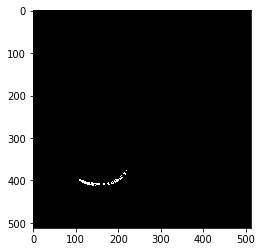

Actual Y


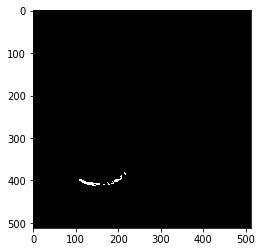

dice score:  tensor(0.9006, device='cuda:0')
Val dice: tensor(0.8866, device='cuda:0')
Pixel acc: -0.002968894650155667
ADCS:  0.11855838463171843


In [29]:
val_dice, pixel_acc, ADCS = eval_net(net, loader_val, device, True)
print("Val dice:", val_dice)
print("Pixel acc:", pixel_acc)
print("ADCS: ", ADCS)

Checking accuracy on val/test set
X


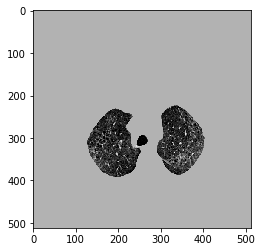

Predicted Y


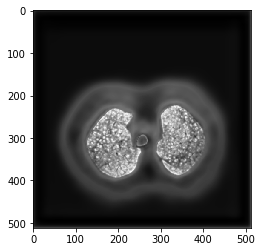

Probs Y


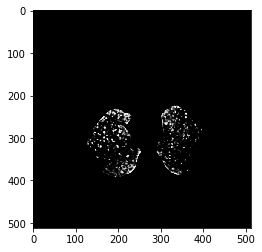

Print Y


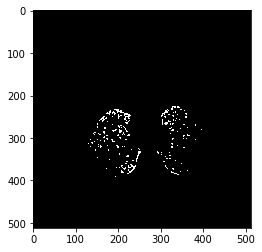

Actual Y


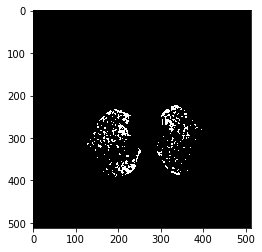

dice score:  tensor(0.6911, device='cuda:0')
X


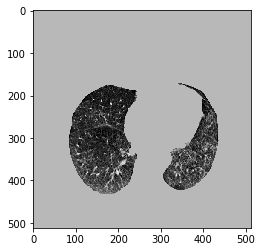

Predicted Y


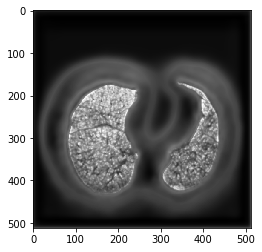

Probs Y


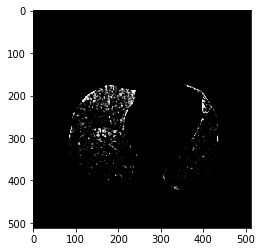

Print Y


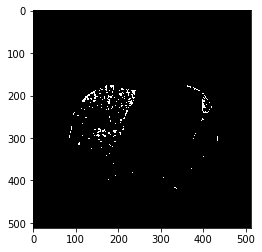

Actual Y


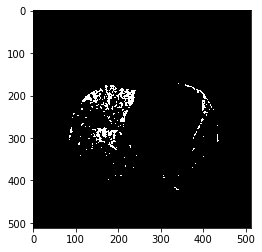

dice score:  tensor(0.6312, device='cuda:0')
X


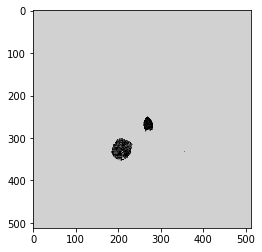

Predicted Y


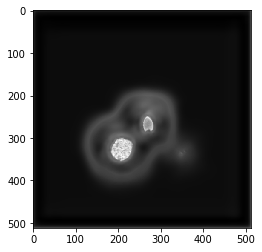

Probs Y


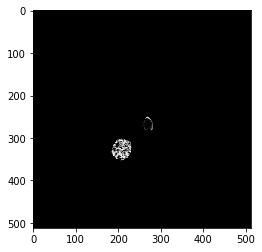

Print Y


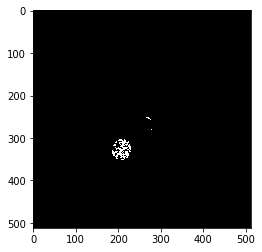

Actual Y


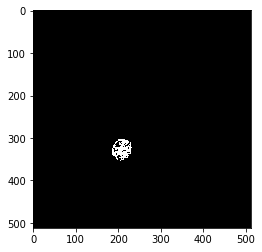

dice score:  tensor(0.6497, device='cuda:0')
X


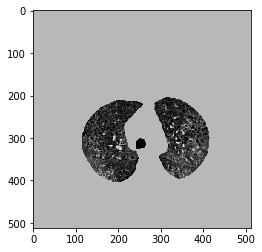

Predicted Y


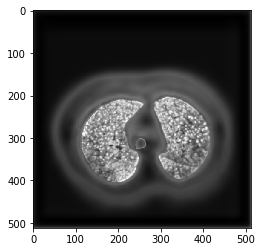

Probs Y


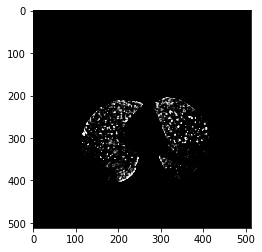

Print Y


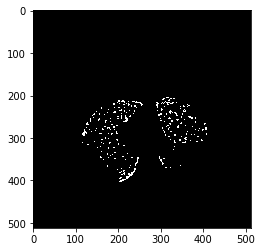

Actual Y


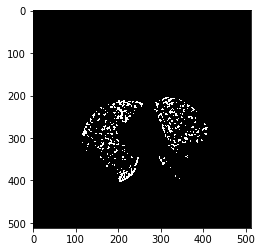

dice score:  tensor(0.6499, device='cuda:0')
X


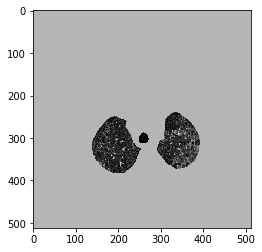

Predicted Y


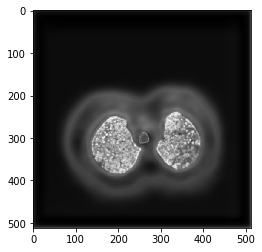

Probs Y


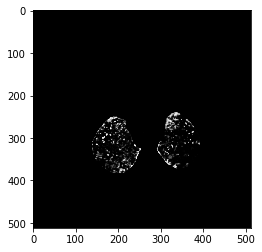

Print Y


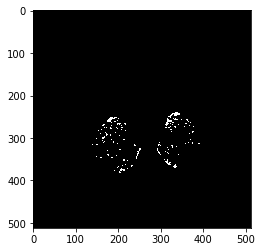

Actual Y


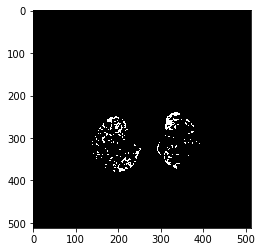

dice score:  tensor(0.6810, device='cuda:0')
X


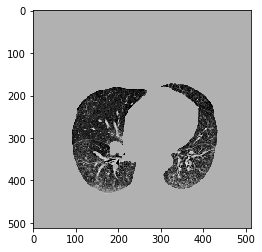

Predicted Y


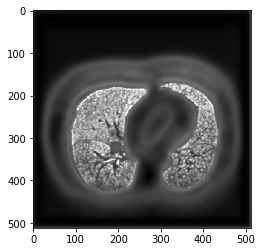

Probs Y


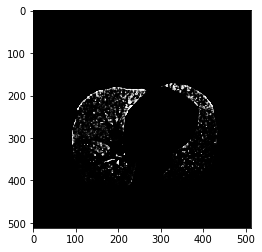

Print Y


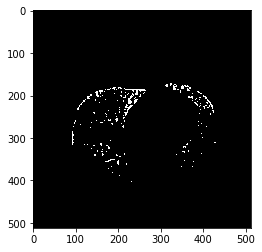

Actual Y


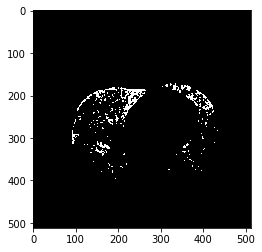

dice score:  tensor(0.9195, device='cuda:0')
X


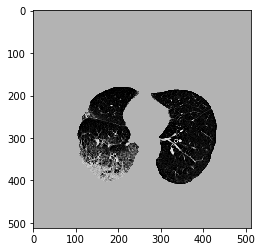

Predicted Y


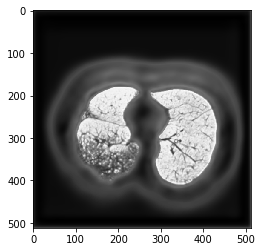

Probs Y


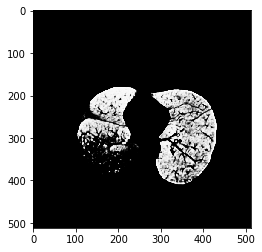

Print Y


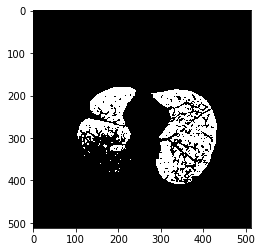

Actual Y


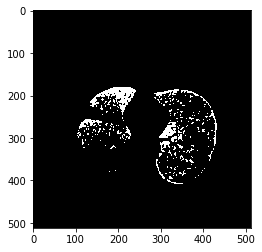

dice score:  tensor(0.9955, device='cuda:0')
X


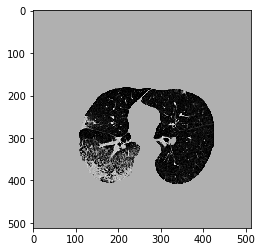

Predicted Y


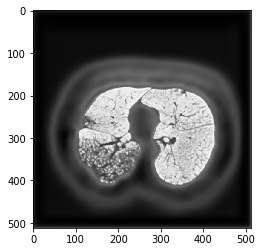

Probs Y


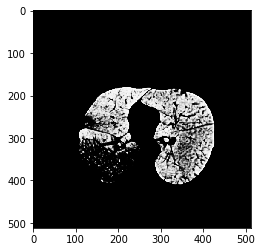

Print Y


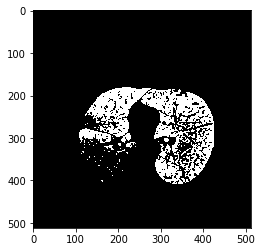

Actual Y


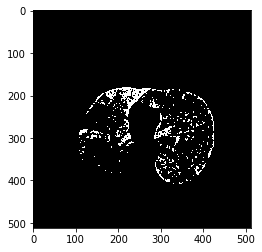

dice score:  tensor(0.9907, device='cuda:0')
X


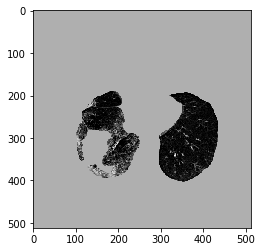

Predicted Y


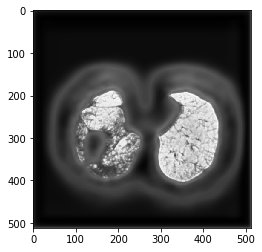

Probs Y


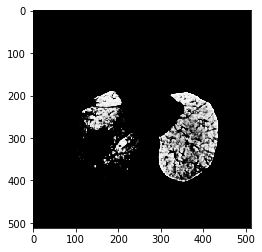

Print Y


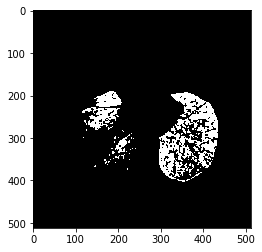

Actual Y


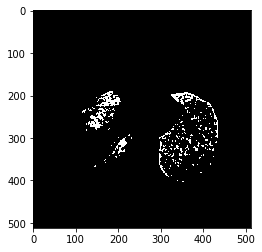

dice score:  tensor(0.9927, device='cuda:0')
X


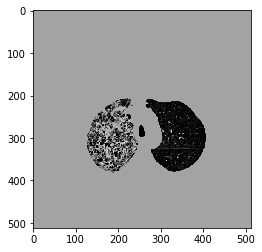

Predicted Y


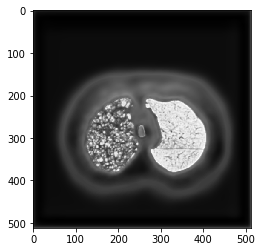

Probs Y


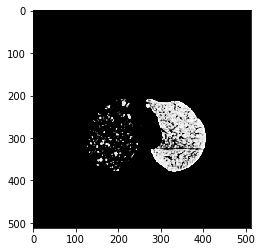

Print Y


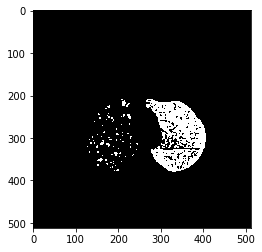

Actual Y


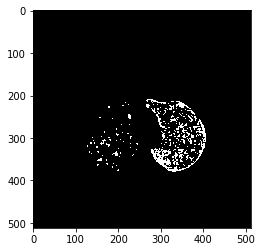

dice score:  tensor(0.9900, device='cuda:0')
X


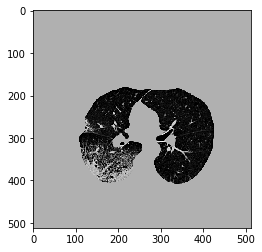

Predicted Y


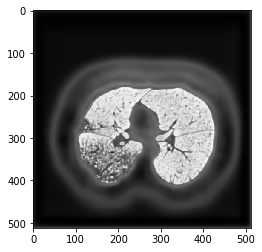

Probs Y


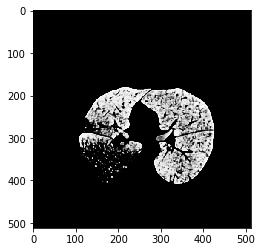

Print Y


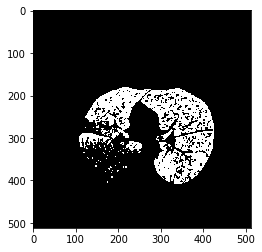

Actual Y


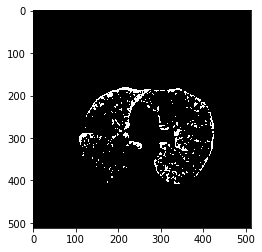

dice score:  tensor(0.9890, device='cuda:0')
X


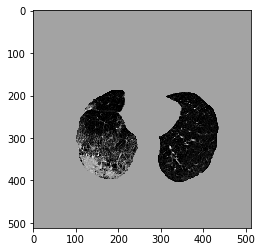

Predicted Y


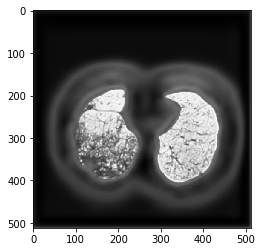

Probs Y


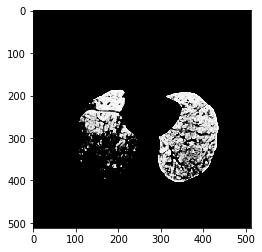

Print Y


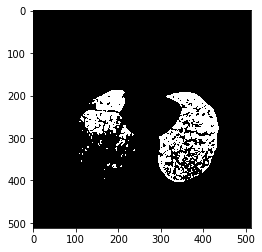

Actual Y


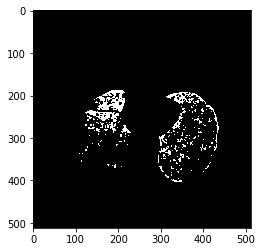

dice score:  tensor(0.9924, device='cuda:0')
X


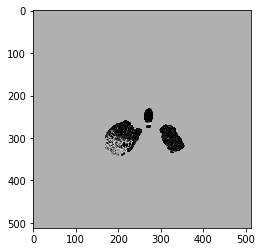

Predicted Y


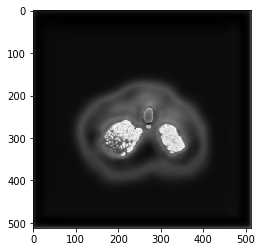

Probs Y


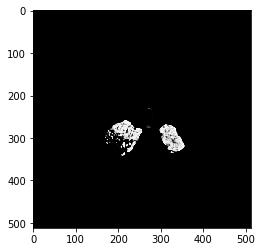

Print Y


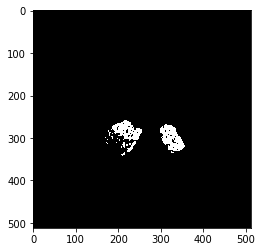

Actual Y


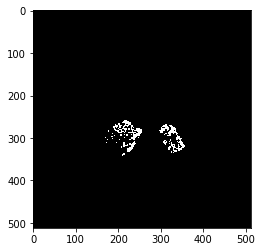

dice score:  tensor(0.9877, device='cuda:0')
X


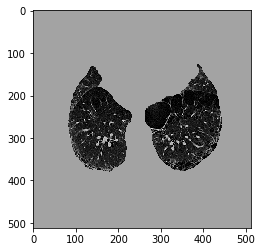

Predicted Y


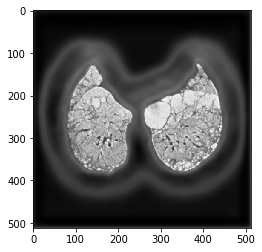

Probs Y


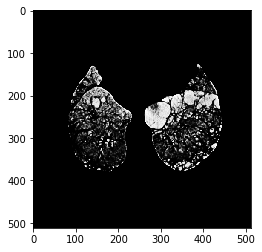

Print Y


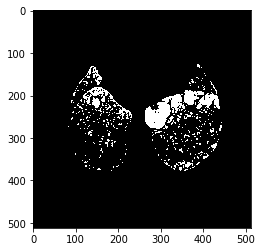

Actual Y


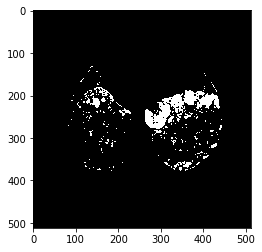

dice score:  tensor(0.9675, device='cuda:0')
X


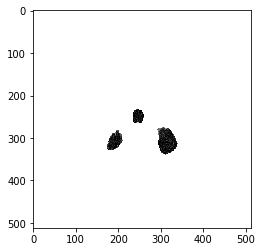

Predicted Y


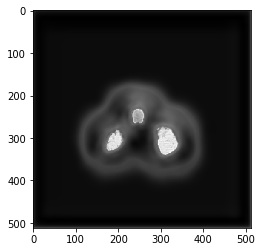

Probs Y


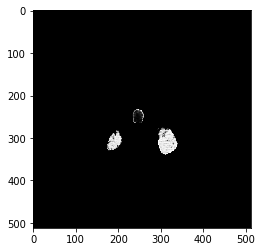

Print Y


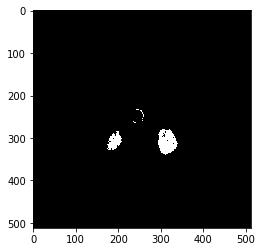

Actual Y


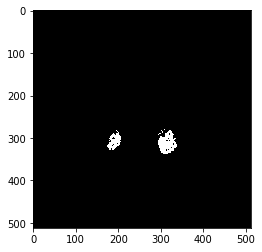

dice score:  tensor(0.9662, device='cuda:0')
X


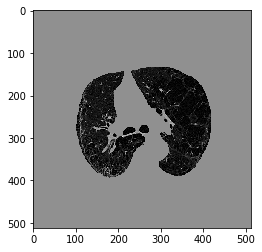

Predicted Y


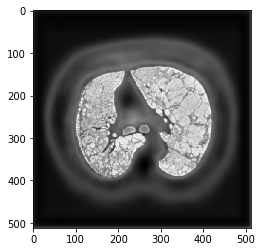

Probs Y


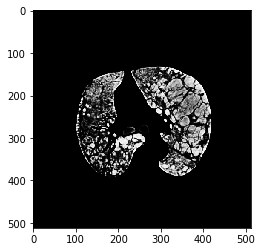

Print Y


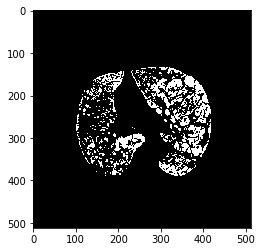

Actual Y


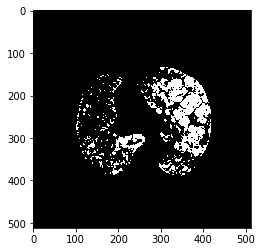

dice score:  tensor(0.9222, device='cuda:0')
X


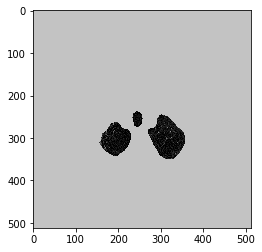

Predicted Y


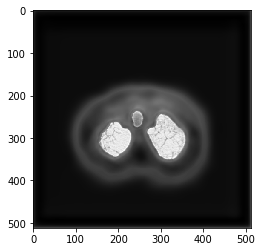

Probs Y


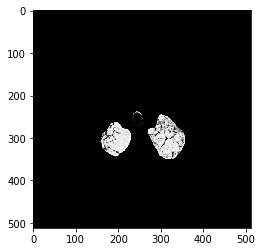

Print Y


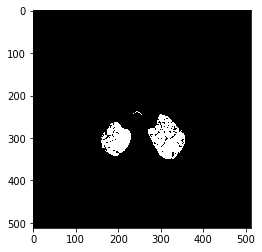

Actual Y


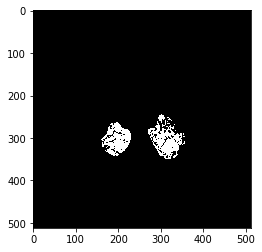

dice score:  tensor(0.9629, device='cuda:0')
X


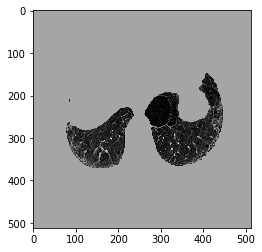

Predicted Y


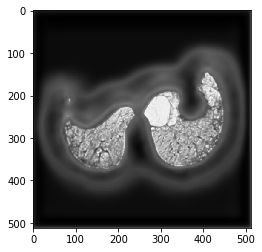

Probs Y


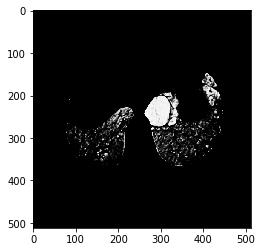

Print Y


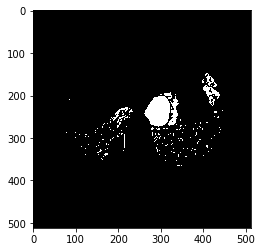

Actual Y


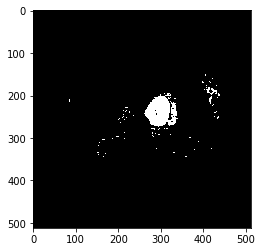

dice score:  tensor(0.9179, device='cuda:0')
X


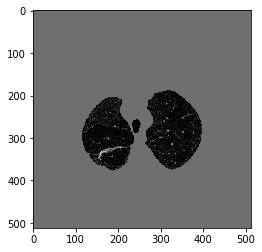

Predicted Y


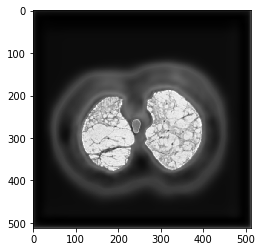

Probs Y


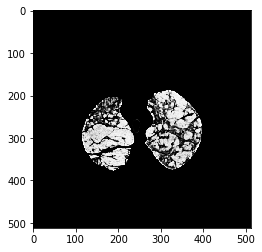

Print Y


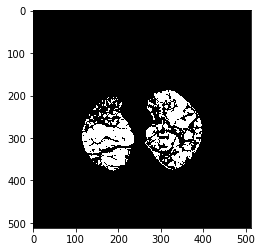

Actual Y


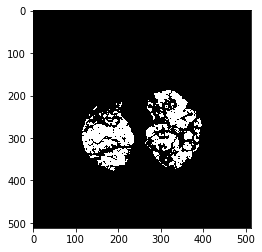

dice score:  tensor(0.9695, device='cuda:0')
X


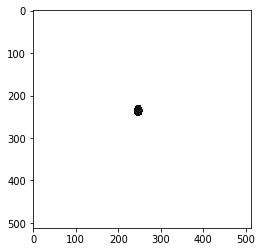

Predicted Y


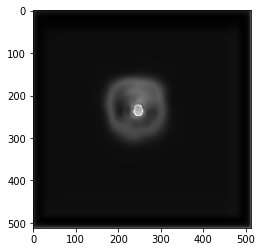

Probs Y


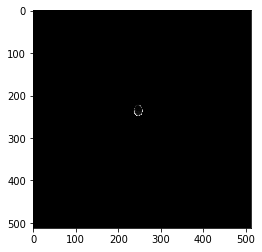

Print Y


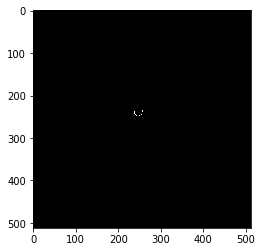

Actual Y


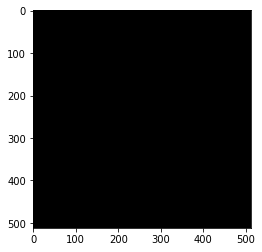

dice score:  tensor(0.9671, device='cuda:0')
X


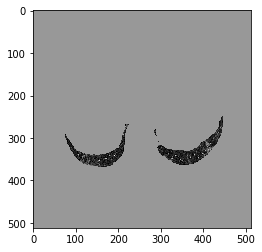

Predicted Y


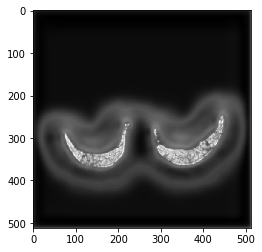

Probs Y


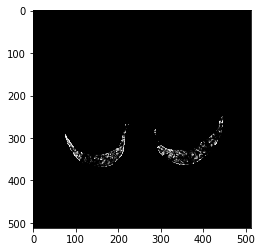

Print Y


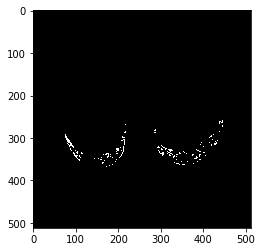

Actual Y


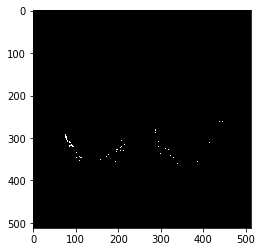

dice score:  tensor(0.9308, device='cuda:0')
X


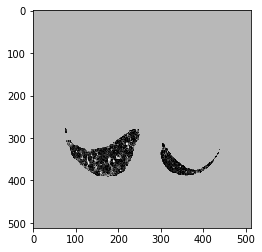

Predicted Y


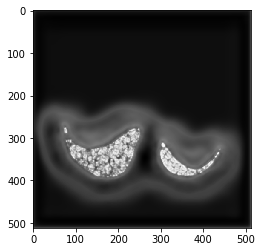

Probs Y


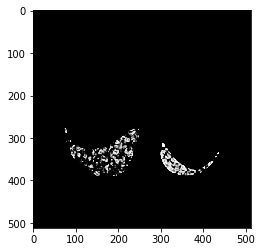

Print Y


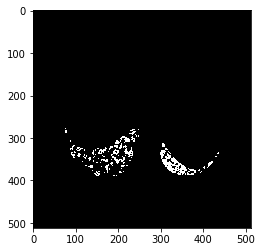

Actual Y


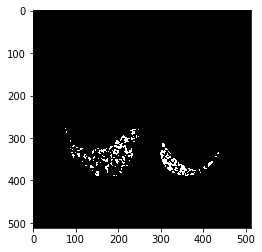

dice score:  tensor(0.9438, device='cuda:0')
X


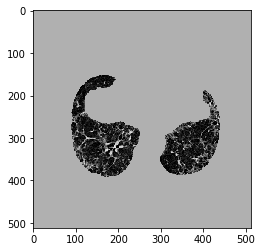

Predicted Y


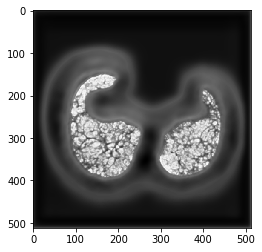

Probs Y


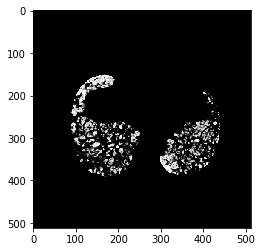

Print Y


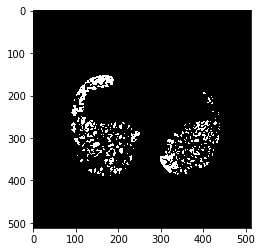

Actual Y


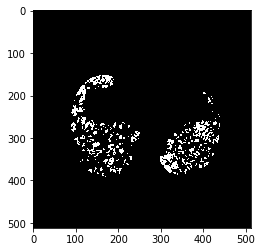

dice score:  tensor(0.9306, device='cuda:0')
X


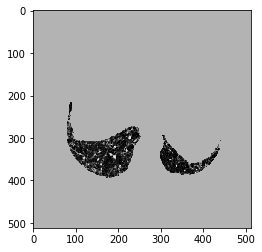

Predicted Y


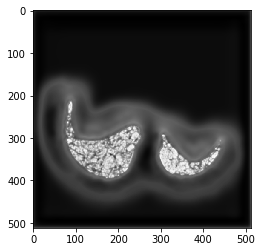

Probs Y


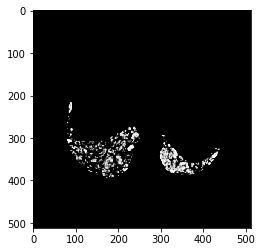

Print Y


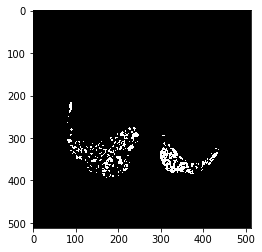

Actual Y


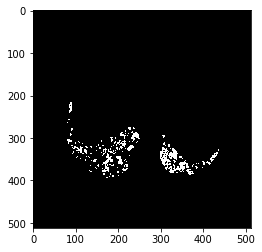

dice score:  tensor(0.9528, device='cuda:0')
X


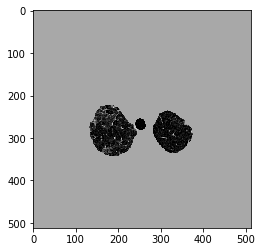

Predicted Y


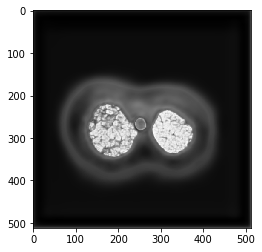

Probs Y


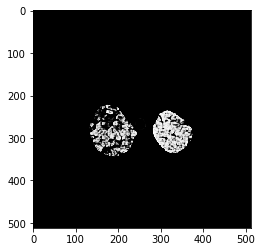

Print Y


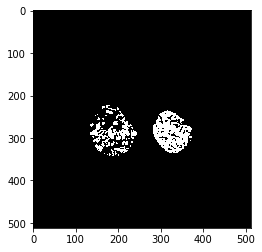

Actual Y


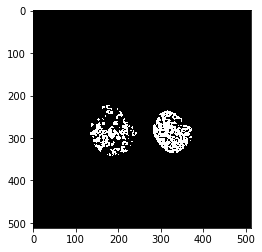

dice score:  tensor(0.9432, device='cuda:0')
X


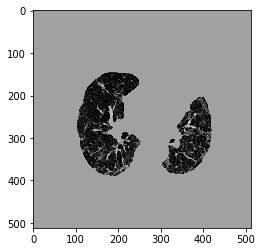

Predicted Y


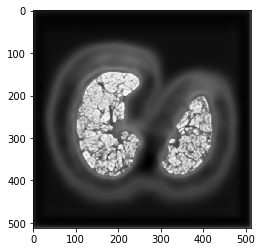

Probs Y


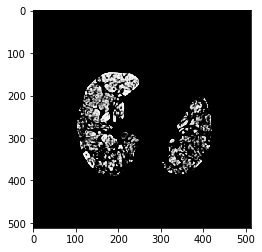

Print Y


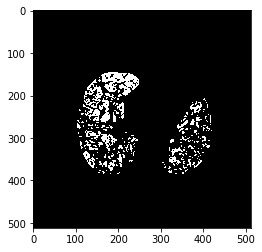

Actual Y


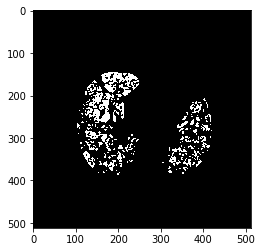

dice score:  tensor(0.9334, device='cuda:0')
X


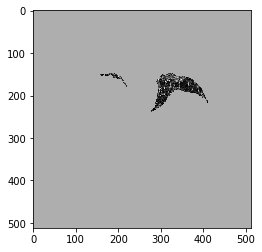

Predicted Y


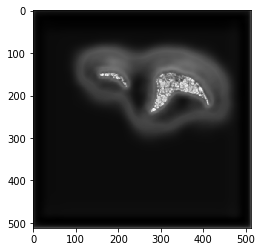

Probs Y


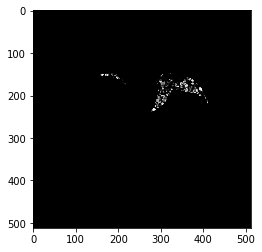

Print Y


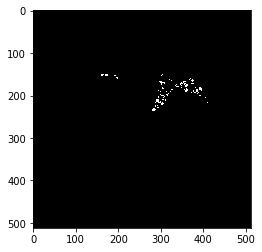

Actual Y


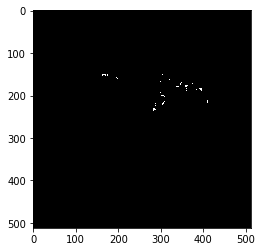

dice score:  tensor(0.9733, device='cuda:0')
X


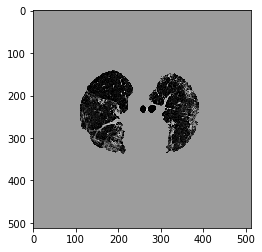

Predicted Y


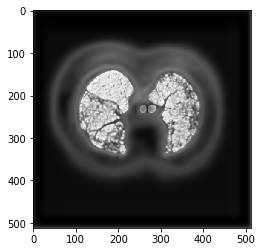

Probs Y


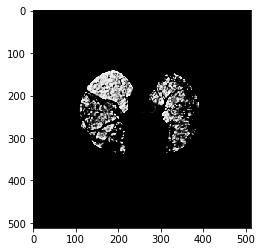

Print Y


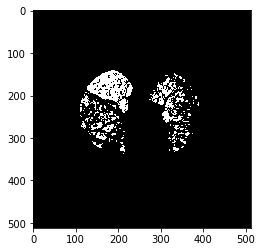

Actual Y


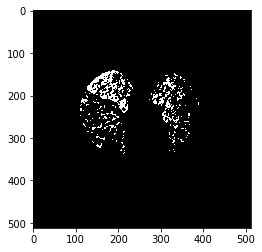

dice score:  tensor(0.9766, device='cuda:0')
X


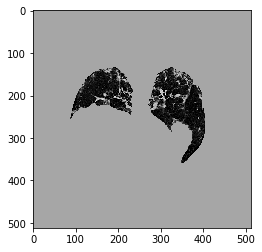

Predicted Y


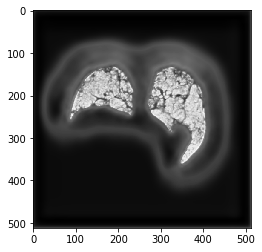

Probs Y


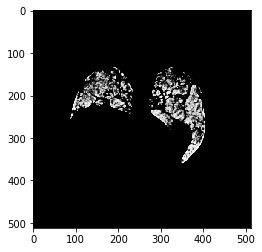

Print Y


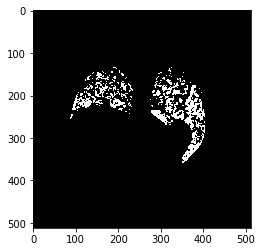

Actual Y


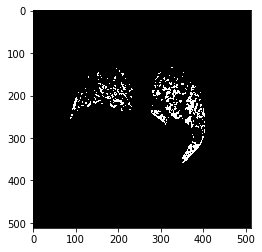

dice score:  tensor(0.9715, device='cuda:0')
X


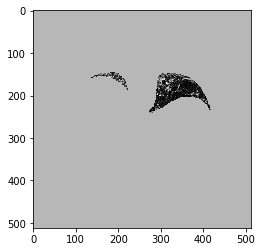

Predicted Y


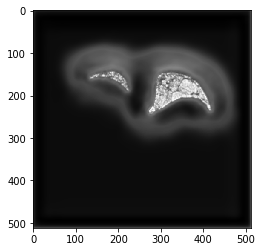

Probs Y


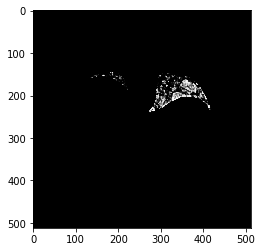

Print Y


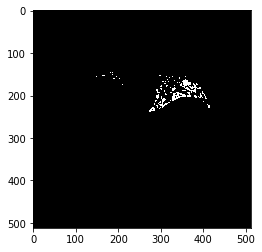

Actual Y


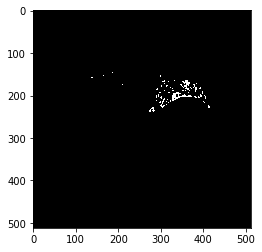

dice score:  tensor(0.9660, device='cuda:0')
X


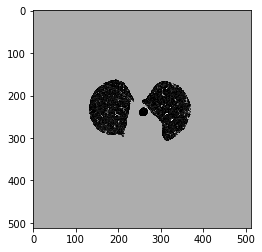

Predicted Y


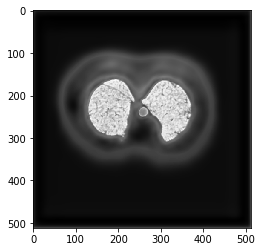

Probs Y


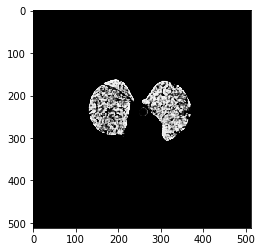

Print Y


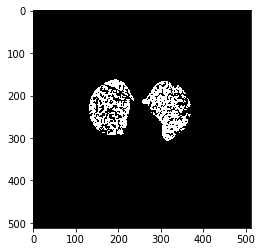

Actual Y


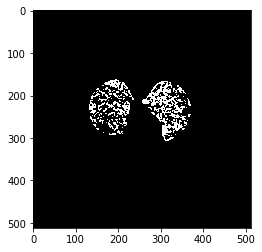

dice score:  tensor(0.9822, device='cuda:0')
X


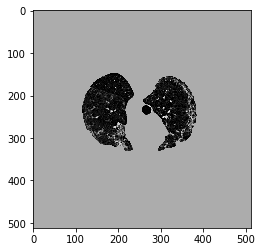

Predicted Y


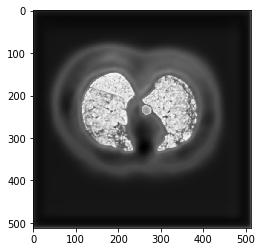

Probs Y


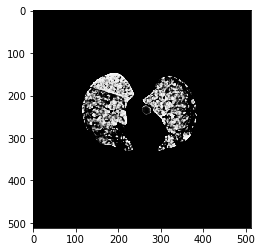

Print Y


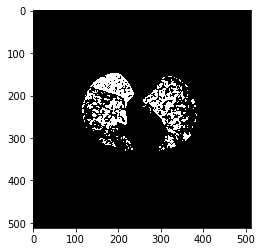

Actual Y


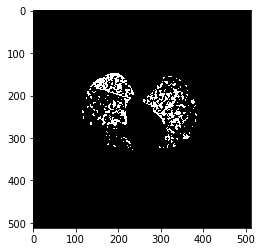

dice score:  tensor(0.9655, device='cuda:0')
X


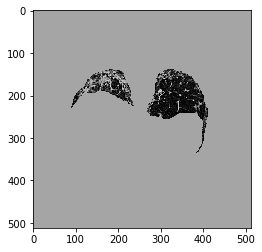

Predicted Y


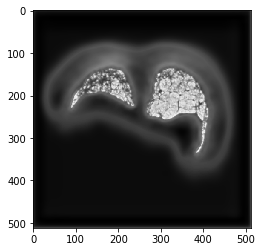

Probs Y


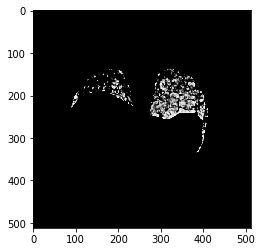

Print Y


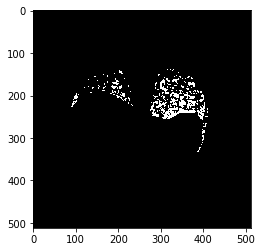

Actual Y


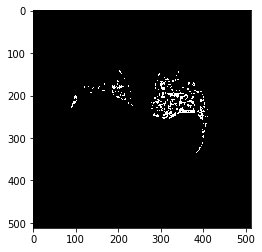

dice score:  tensor(0.5544, device='cuda:0')
X


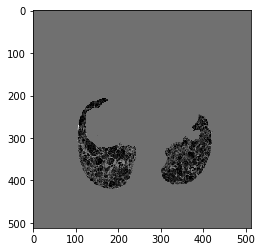

Predicted Y


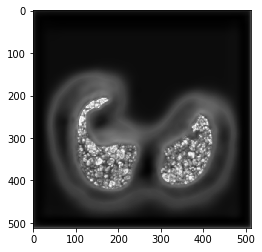

Probs Y


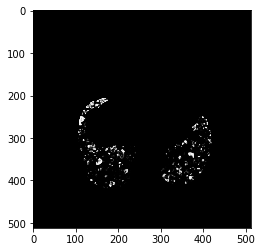

Print Y


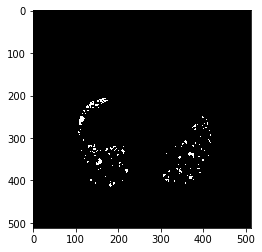

Actual Y


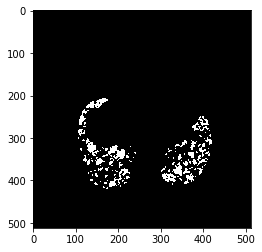

dice score:  tensor(0.4548, device='cuda:0')
X


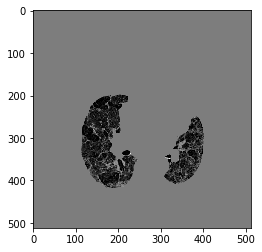

Predicted Y


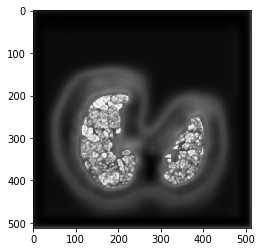

Probs Y


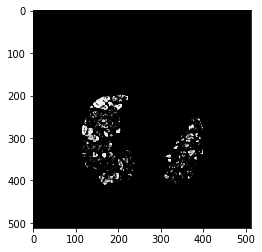

Print Y


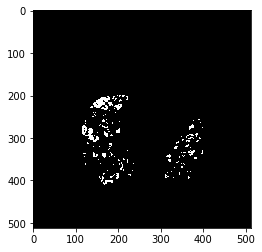

Actual Y


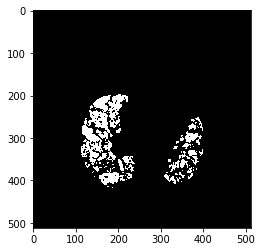

dice score:  tensor(0.4363, device='cuda:0')
X


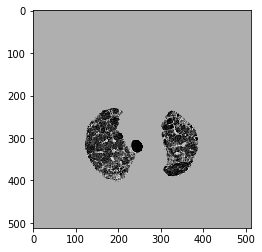

Predicted Y


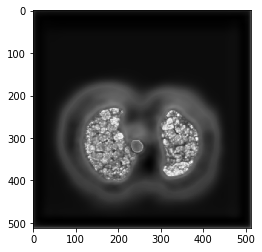

Probs Y


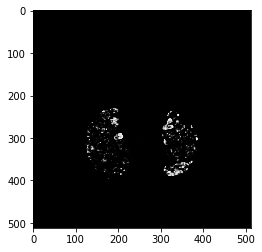

Print Y


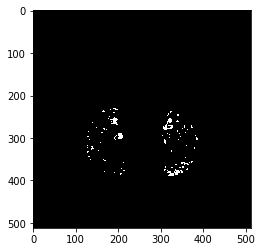

Actual Y


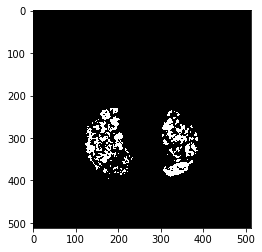

dice score:  tensor(0.3950, device='cuda:0')
X


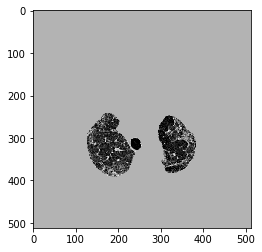

Predicted Y


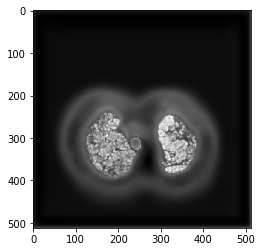

Probs Y


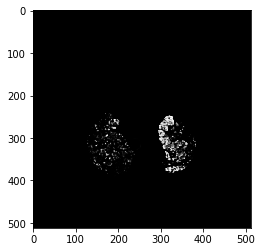

Print Y


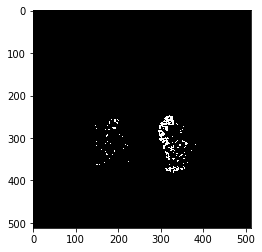

Actual Y


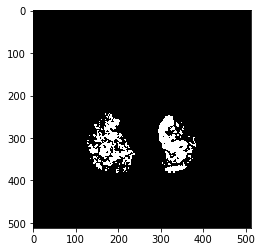

dice score:  tensor(0.3609, device='cuda:0')
X


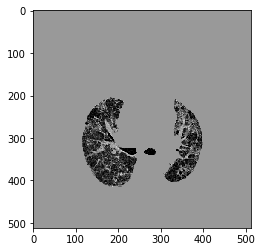

Predicted Y


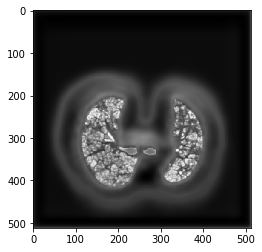

Probs Y


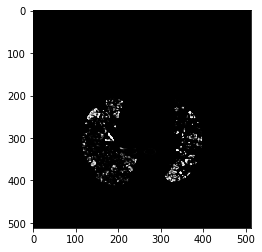

Print Y


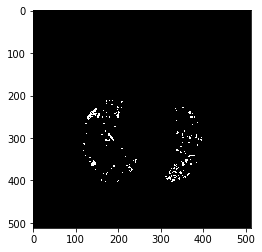

Actual Y


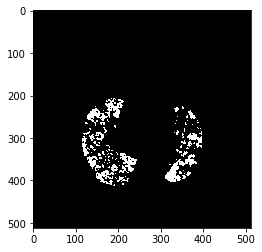

dice score:  tensor(0.3931, device='cuda:0')
Test dice: tensor(0.8394, device='cuda:0')
Pixel acc: -0.0028102678653096364
ADCS:  0.7543253756716499


In [30]:
val_dice, pixel_acc, ADCS = eval_net(net, loader_test, device, True)
print("Test dice:", val_dice)
print("Pixel acc:", pixel_acc)
print("ADCS: ", ADCS)